In [1]:
import sys
sys.path.append('../')
from datasets import load_dataset
from utils.data import split_data
import pandas as pd
import numpy as np
from utils.plotting import scatter
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as Knn
from utils.pca import PCA


In [2]:
def test_knn_no_cross(data: pd.DataFrame, max_k, shuffle = False) -> list:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)
  train, test = split_data(data, (0.8, 0.2))
  result = [np.NAN]
  train_feature = train.loc[:, train.columns != 'class']
  test_feature = test.loc[:, test.columns != 'class']
  for i in range(1, max_k + 1):
    model = Knn(i)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    result.append(np.mean(prediction == test["class"].values) )

  return result

In [3]:
def test_knn_k_fold(data: pd.DataFrame, k, fold, shuffle = False) -> float:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)

  subsets = split_data(data, [1 / fold for c in range(fold)])

  folds = []
  for i in range(fold):
    test = subsets[i]
    train = pd.concat((*subsets[:i], *subsets[i+1:]))

    train_feature = train.loc[:, train.columns != 'class']
    test_feature = test.loc[:, test.columns != 'class']

    model = Knn(k)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    folds.append(np.mean(prediction == test["class"].values))

  return np.mean(folds)

In [4]:
def test_knn_leave_one_out(data: pd.DataFrame, k, shuffle=False) -> float:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)

  rows = len(data)
  result = []
  for i in range(rows):
    test = data[i: i+1]
    train = pd.concat((data[ : i], data[i+1: ]))
    train_feature = train.loc[:, train.columns != 'class']
    test_feature = test.loc[:, test.columns != 'class']
    model = Knn(k)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    result.append(np.mean(prediction == test["class"].values))
  
  return np.mean(result)

In [13]:
iris_data, iris_features = load_dataset.iris(shuffle=True)
rice_data, rice_features = load_dataset.rice(shuffle=True)

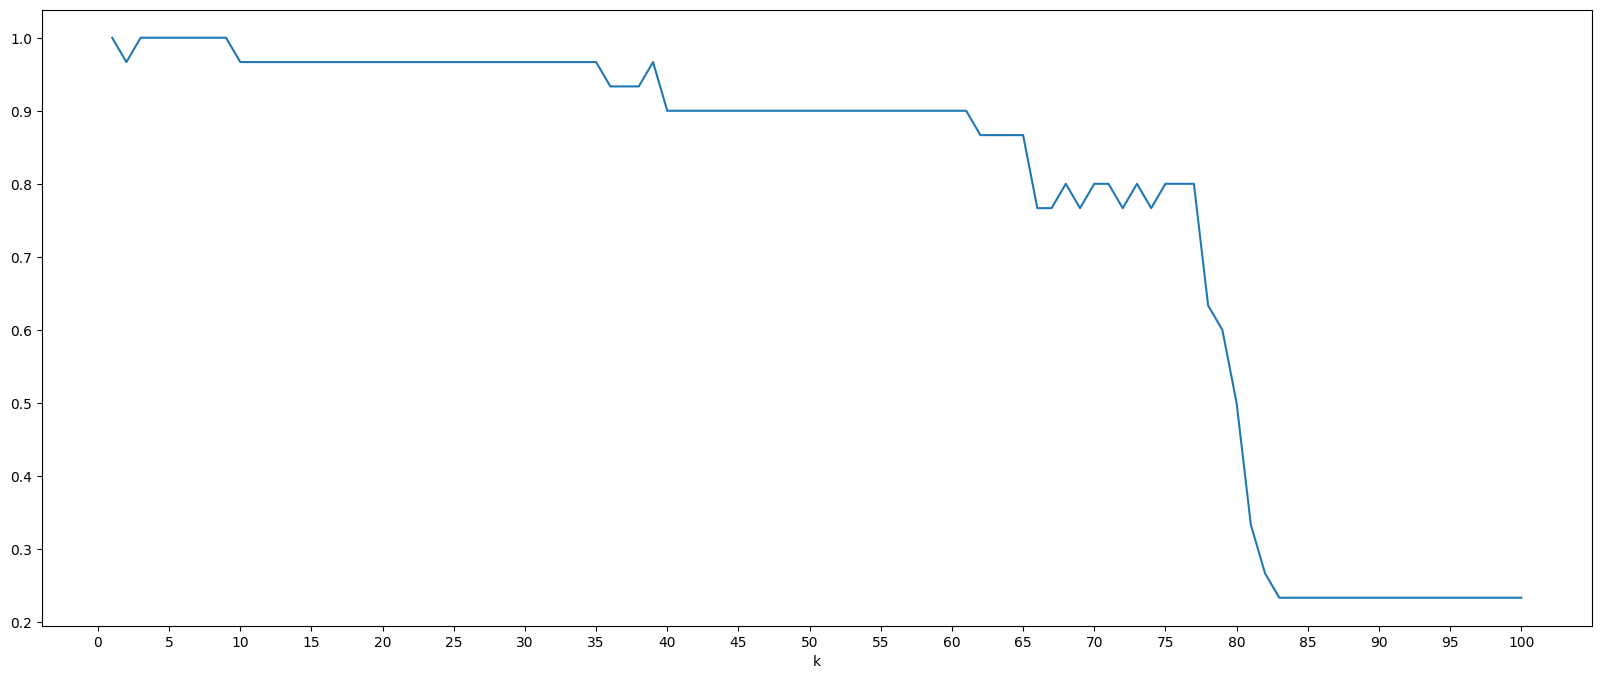

In [14]:
iris_performance = test_knn_no_cross(iris_data, 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(iris_performance)

In [55]:
np.min(iris_performance[1:]), np.max(iris_performance[1:]), np.average(iris_performance[1:])

(0.8451443569553806, 0.8871391076115486, 0.8764041994750655)

In [30]:
rice_data, rice_features = load_dataset.rice(shuffle=True)

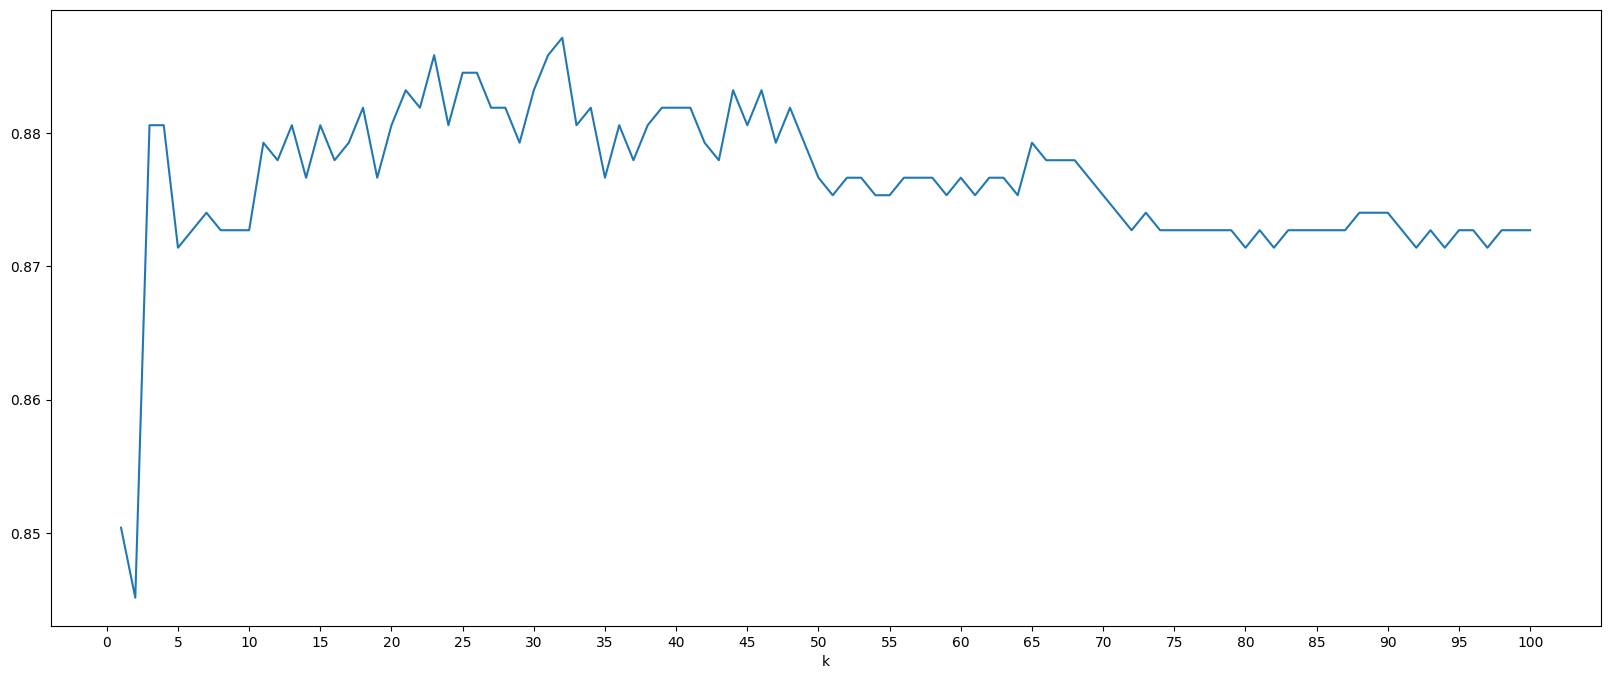

In [31]:
rice_performance = test_knn_no_cross(rice_data, 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(rice_performance)

In [56]:
np.min(rice_performance[1:]), np.max(rice_performance[1:]), np.average(rice_performance[1:])

(0.8451443569553806, 0.8871391076115486, 0.8764041994750655)

In [84]:
wine_data, wine_features = load_dataset.wine(shuffle=True)

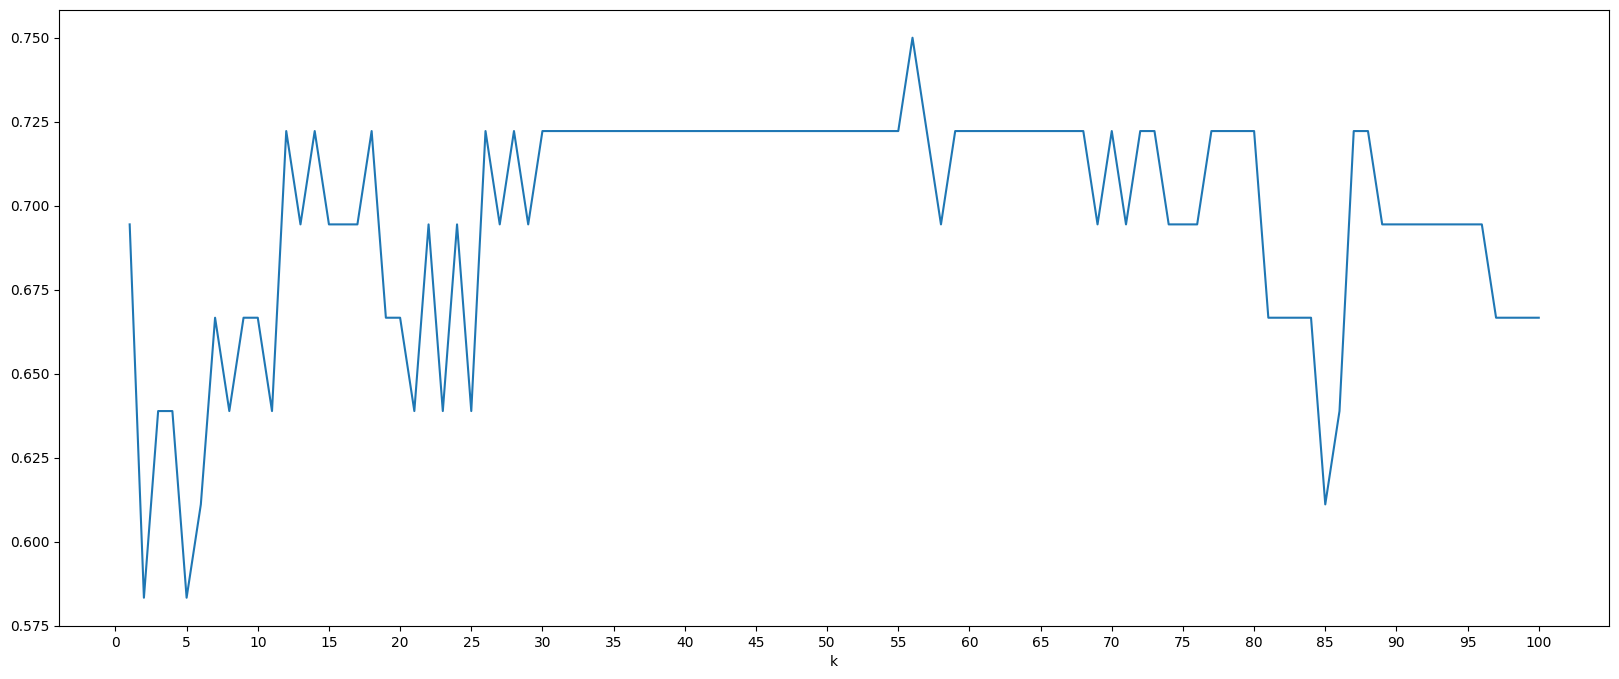

In [85]:
wine_performance = test_knn_no_cross(wine_data, 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(wine_performance)

In [86]:
np.min(wine_performance[1:]), np.max(wine_performance[1:]), np.average(wine_performance[1:])


(0.5833333333333334, 0.75, 0.6972222222222224)

In [17]:
def standardization(data: pd.DataFrame) -> pd.DataFrame:
  normalize_data = (data - data.mean()) / data.std()
  return normalize_data

def min_max_normalize(data: pd.DataFrame) -> pd.DataFrame:
  normalize_data = (data - data.min()) / (data.max() - data.min())
  return normalize_data

In [8]:
def with_class(data: pd.DataFrame, labels):
  new_data = data.copy()
  new_data["class"] = labels
  return new_data

### Iris

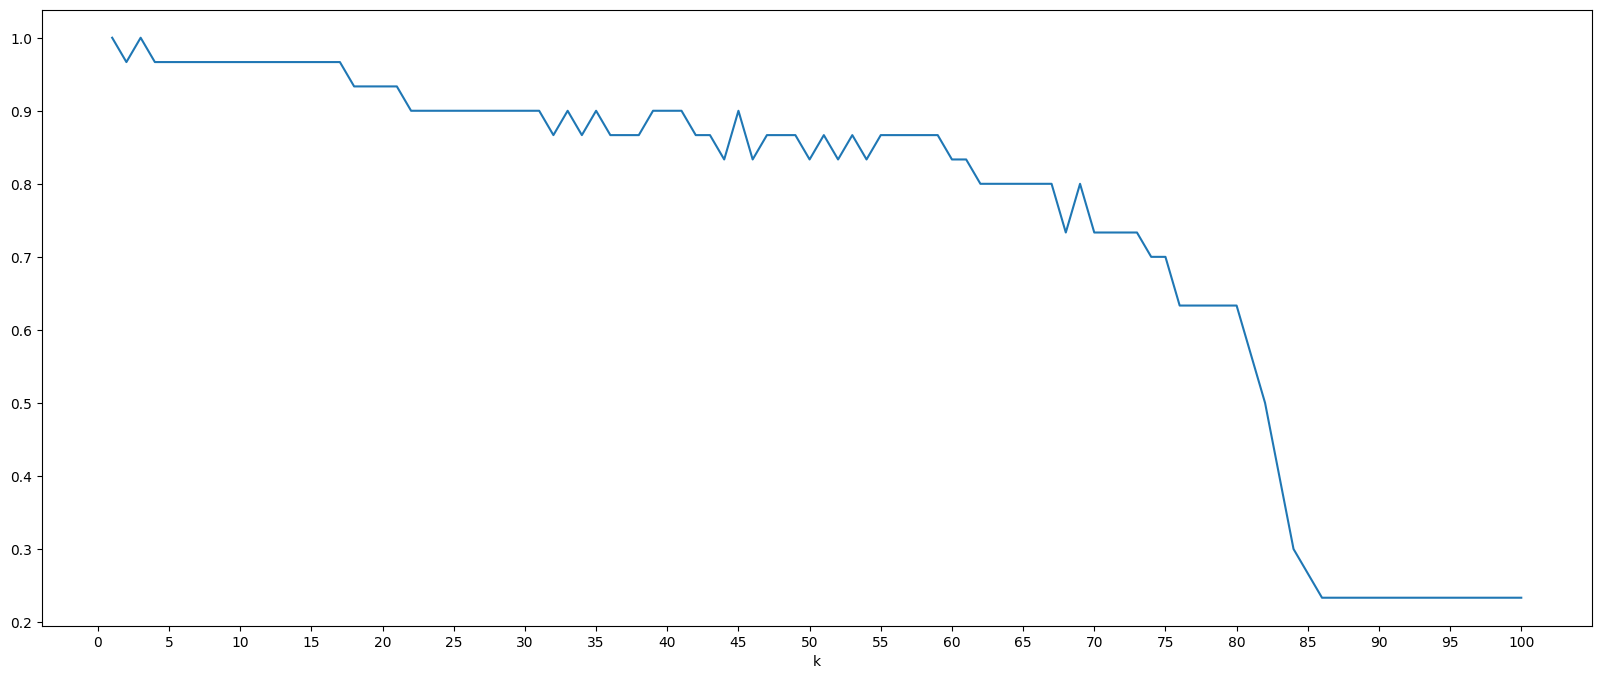

In [18]:
iris_standardization = standardization(iris_features)
iris_standardization_performance = test_knn_no_cross(with_class(iris_standardization, iris_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(iris_standardization_performance)

In [58]:
np.min(iris_standardization_performance[1:]), np.max(iris_standardization_performance[1:]), np.average(iris_standardization_performance[1:])


(0.23333333333333334, 1.0, 0.7456666666666666)

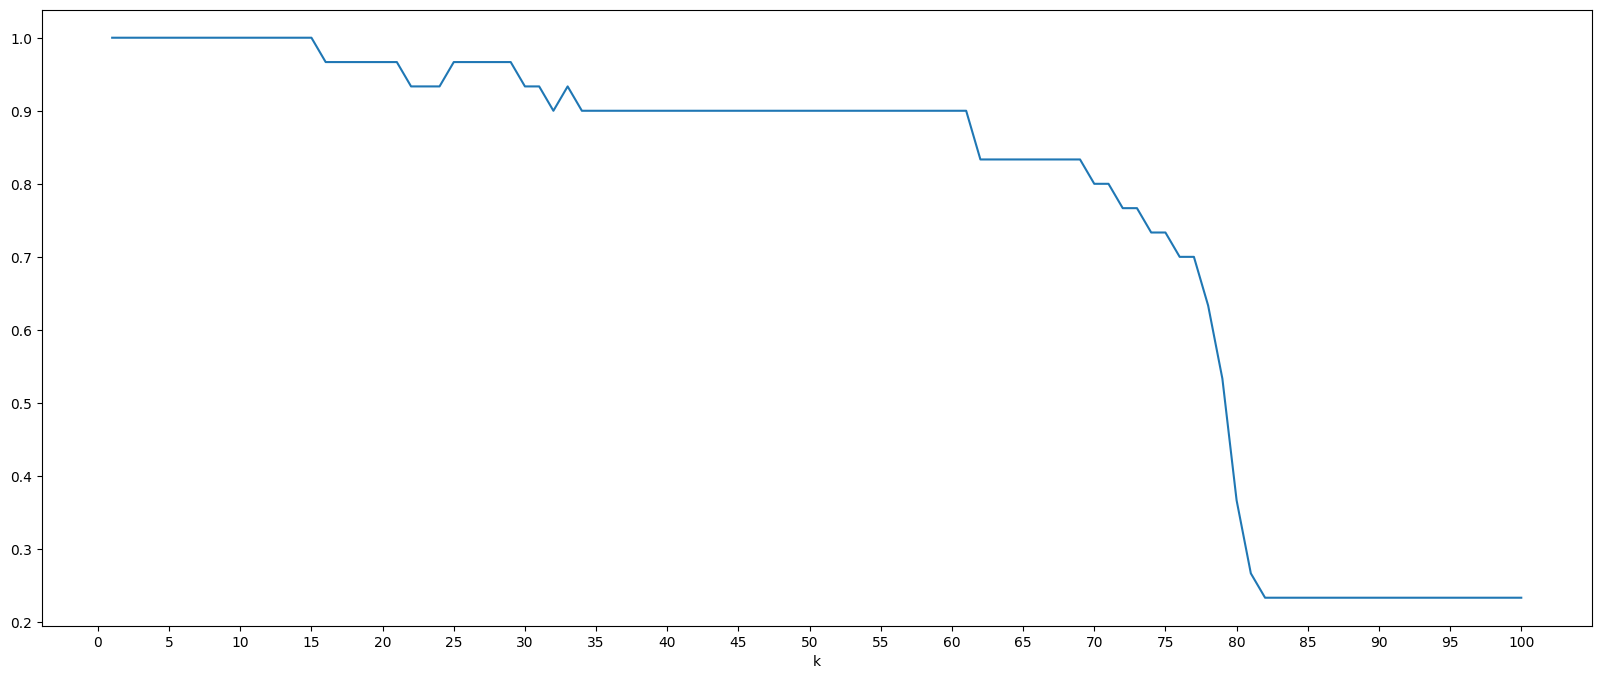

In [16]:
iris_min_max_normalize = min_max_normalize(iris_features)
iris_min_max_normalize_performance = test_knn_no_cross(with_class(iris_min_max_normalize, iris_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(iris_min_max_normalize_performance)

In [61]:
np.min(iris_min_max_normalize_performance[1:]), np.max(iris_min_max_normalize_performance[1:]), np.average(iris_min_max_normalize_performance[1:])

(0.23333333333333334, 1.0, 0.7623333333333335)

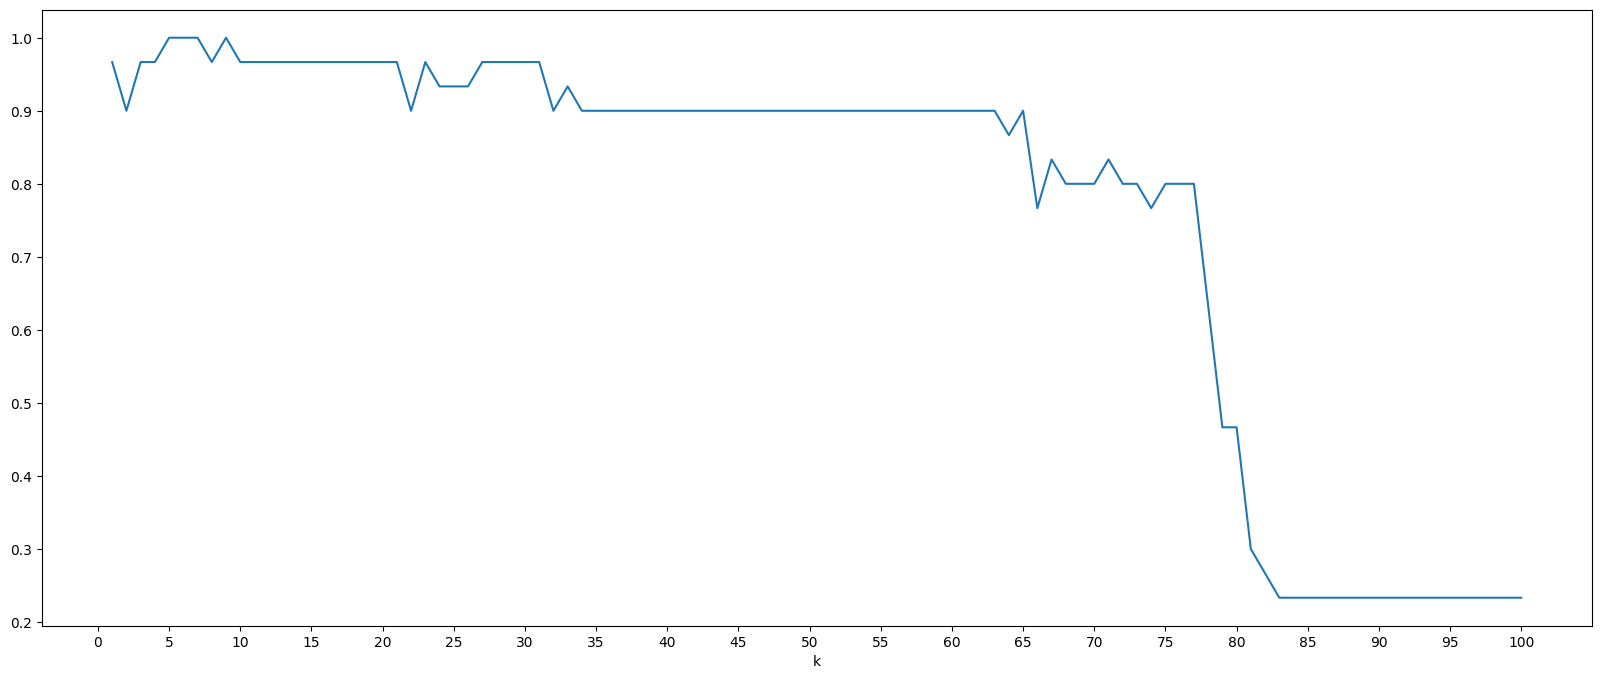

In [19]:
iris_pca = PCA(iris_features, iris_data["class"])
iris_pca_performance = test_knn_no_cross(iris_pca.project(2), 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(iris_pca_performance)

In [126]:
iris_pca.per_var_of(2)

0.9776317750248031

In [62]:
np.min(iris_pca_performance[1:]), np.max(iris_pca_performance[1:]), np.average(iris_pca_performance[1:])


(0.23333333333333334, 1.0, 0.764)

### Rice

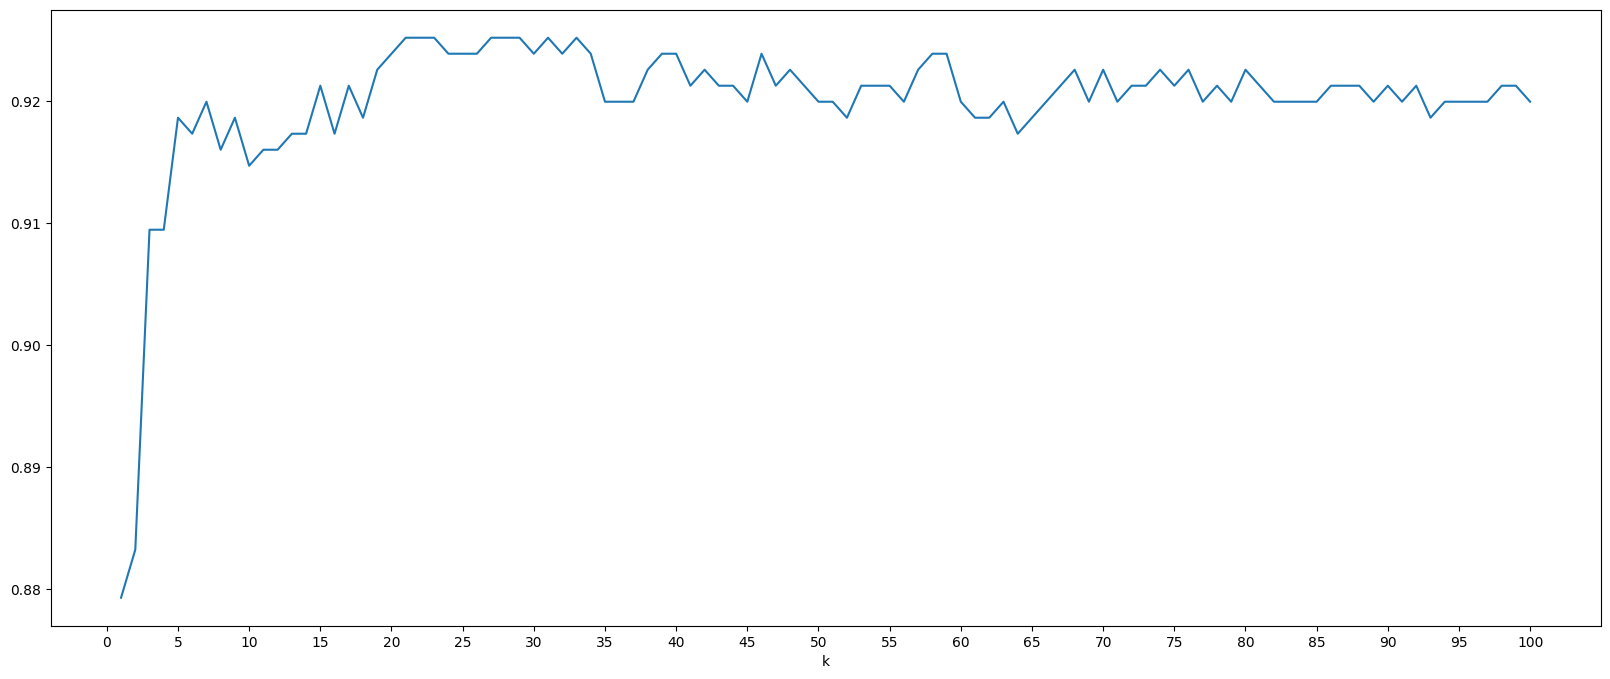

In [32]:
rice_standardization = standardization(rice_features)
rice_standardization_performance = test_knn_no_cross(with_class(rice_standardization, rice_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(rice_standardization_performance)

In [59]:
np.min(rice_standardization_performance[1:]), np.max(rice_standardization_performance[1:]), np.average(rice_standardization_performance[1:])


(0.8792650918635171, 0.9251968503937008, 0.9200131233595803)

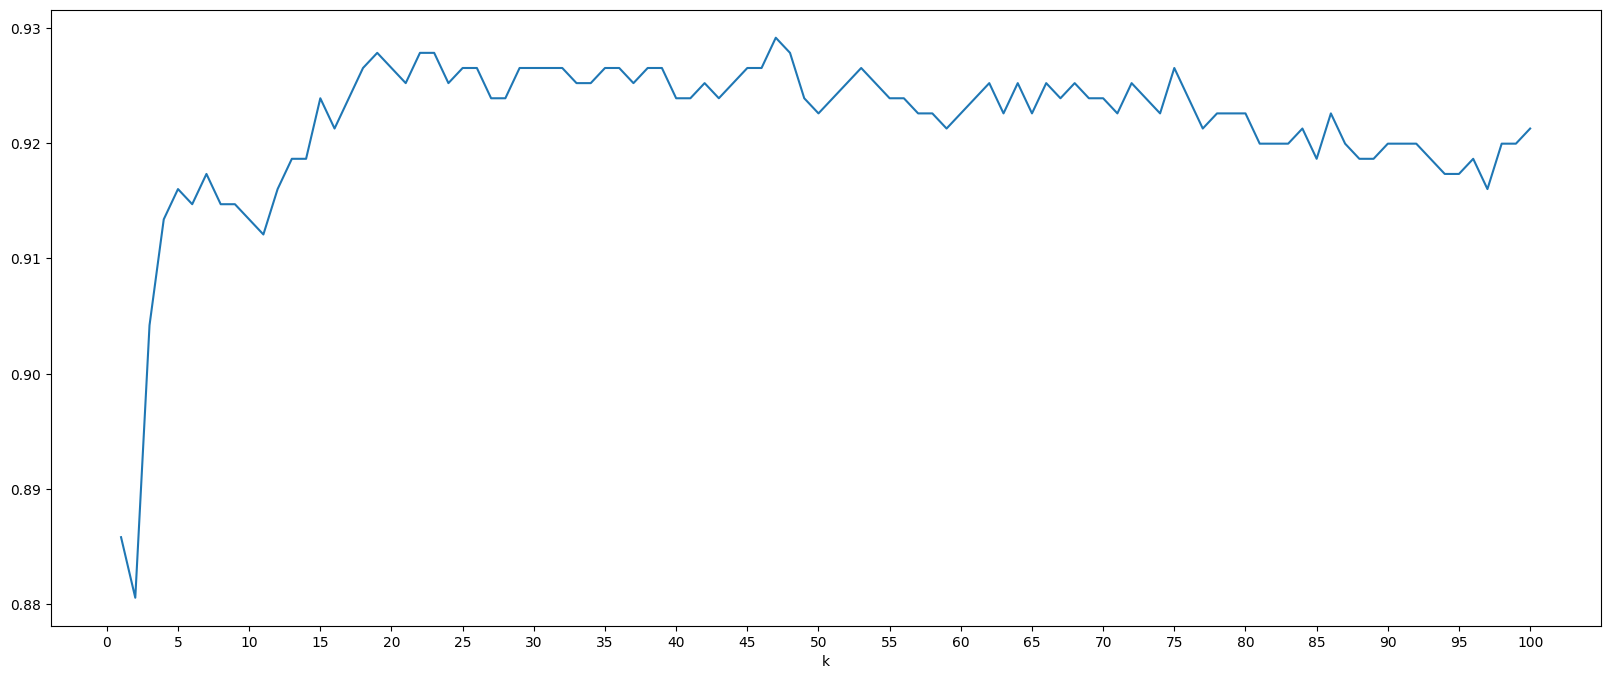

In [33]:
rice_min_max_normalize = min_max_normalize(rice_features)
rice_min_max_normalize_performance = test_knn_no_cross(with_class(rice_min_max_normalize, rice_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(rice_min_max_normalize_performance)

In [63]:
np.min(rice_min_max_normalize_performance[1:]), np.max(rice_min_max_normalize_performance[1:]), np.average(rice_min_max_normalize_performance[1:])


(0.8805774278215223, 0.9291338582677166, 0.9216404199475068)

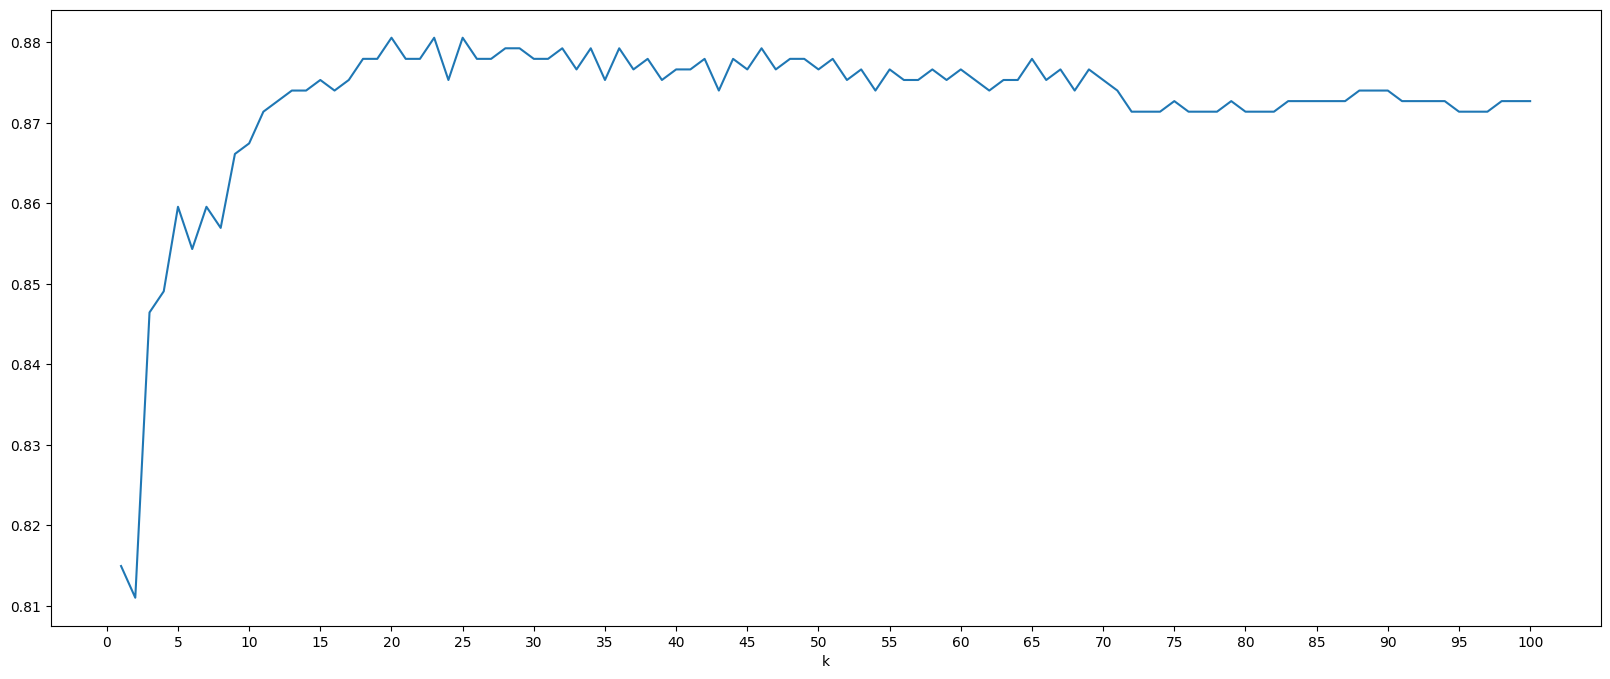

In [34]:
rice_pca = PCA(rice_features, rice_data["class"])
rice_pca_performance = test_knn_no_cross(rice_pca.project(2), 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(rice_pca_performance)

In [64]:
np.min(rice_pca_performance[1:]), np.max(rice_pca_performance[1:]), np.average(rice_pca_performance[1:])

(0.8110236220472441, 0.8805774278215223, 0.8725590551181103)

### Wine

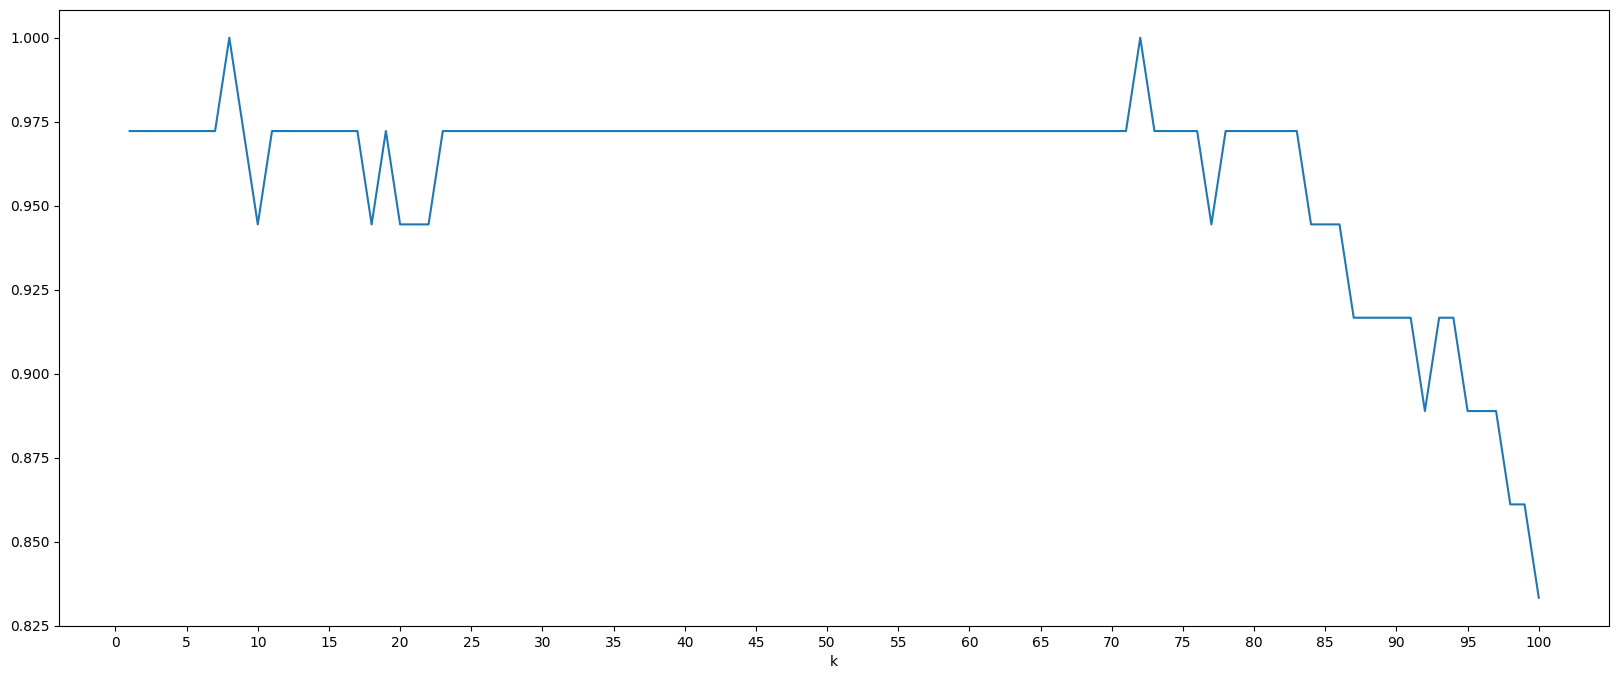

In [87]:
wine_standardization = standardization(wine_features)
wine_standardization_performance = test_knn_no_cross(with_class(wine_standardization, wine_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(wine_standardization_performance)

In [88]:
np.min(wine_standardization_performance[1:]), np.max(wine_standardization_performance[1:]), np.average(wine_standardization_performance[1:])

(0.8333333333333334, 1.0, 0.9594444444444444)

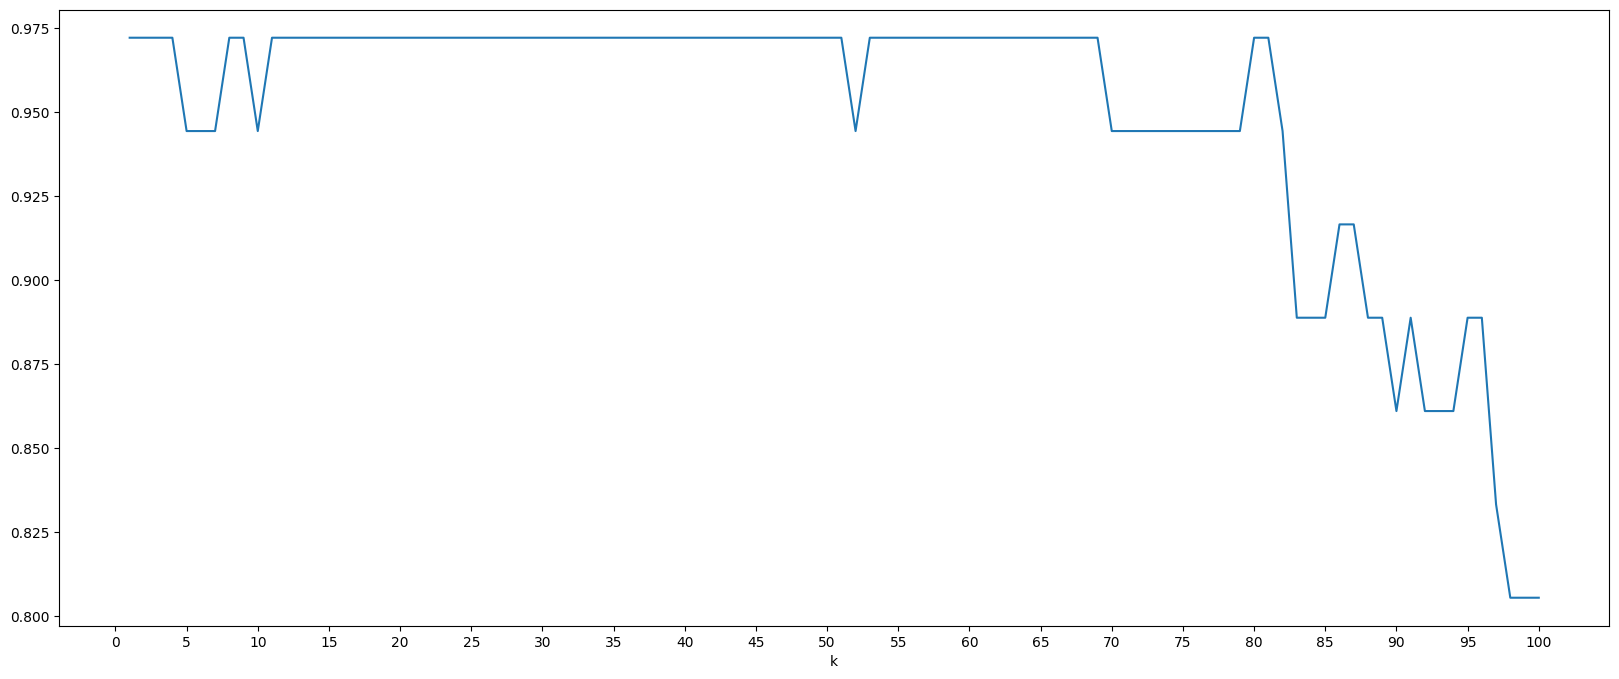

In [89]:
wine_min_max_normalize = min_max_normalize(wine_features)
wine_min_max_normalize_performance = test_knn_no_cross(with_class(wine_min_max_normalize, wine_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(wine_min_max_normalize_performance)

In [141]:
np.min(wine_min_max_normalize_performance[1:]), np.max(wine_min_max_normalize_performance[1:]), np.average(wine_min_max_normalize_performance[1:])

(0.8055555555555556, 0.9722222222222222, 0.9491666666666667)

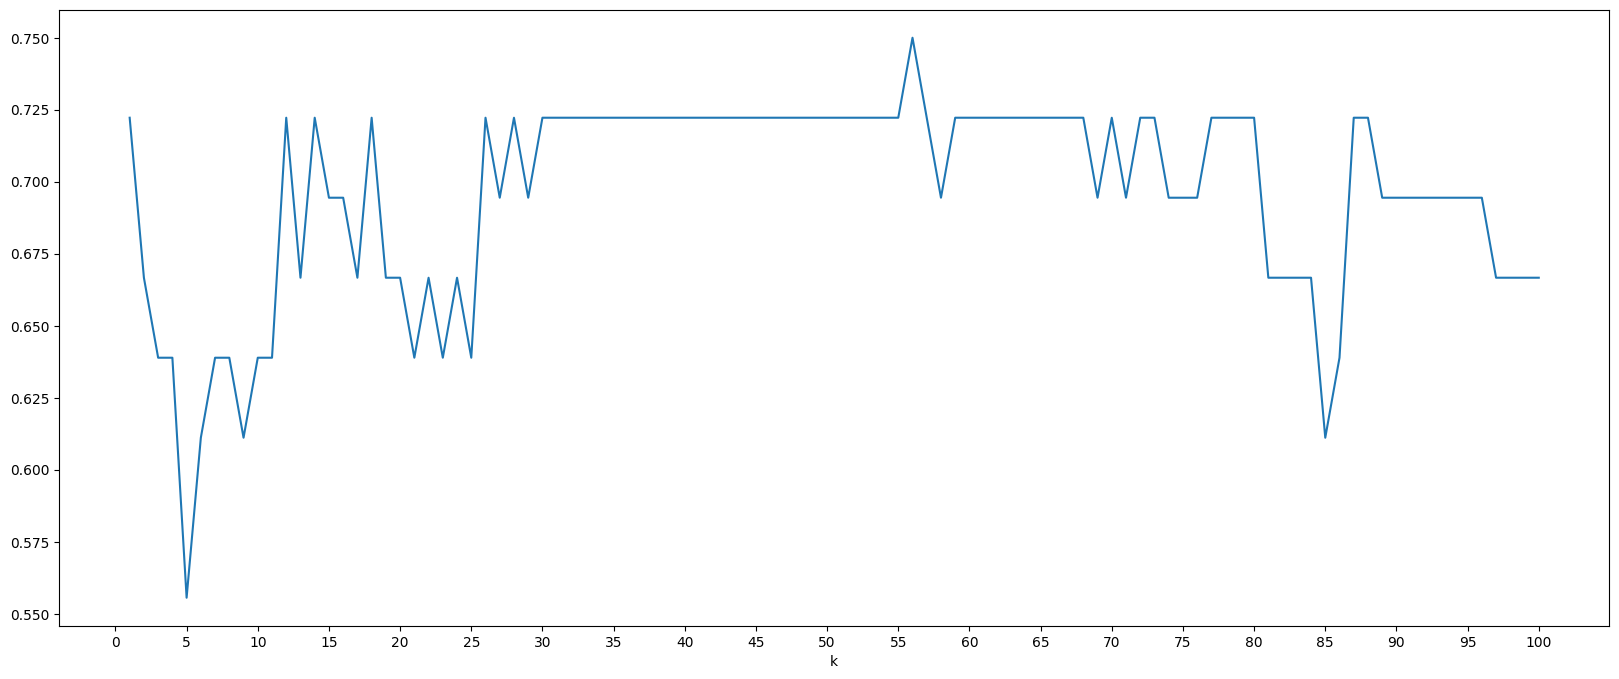

In [144]:
wine_pca = PCA(wine_features, wine_data["class"])
wine_pca_performance = test_knn_no_cross(wine_pca.project(2), 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(wine_pca_performance)

In [94]:
np.min(wine_pca_performance[1:]), np.max(wine_pca_performance[1:]), np.average(wine_pca_performance[1:])

(0.5555555555555556, 0.75, 0.6958333333333334)

# K-fold

### Iris

Text(0.5, 0, 'k')

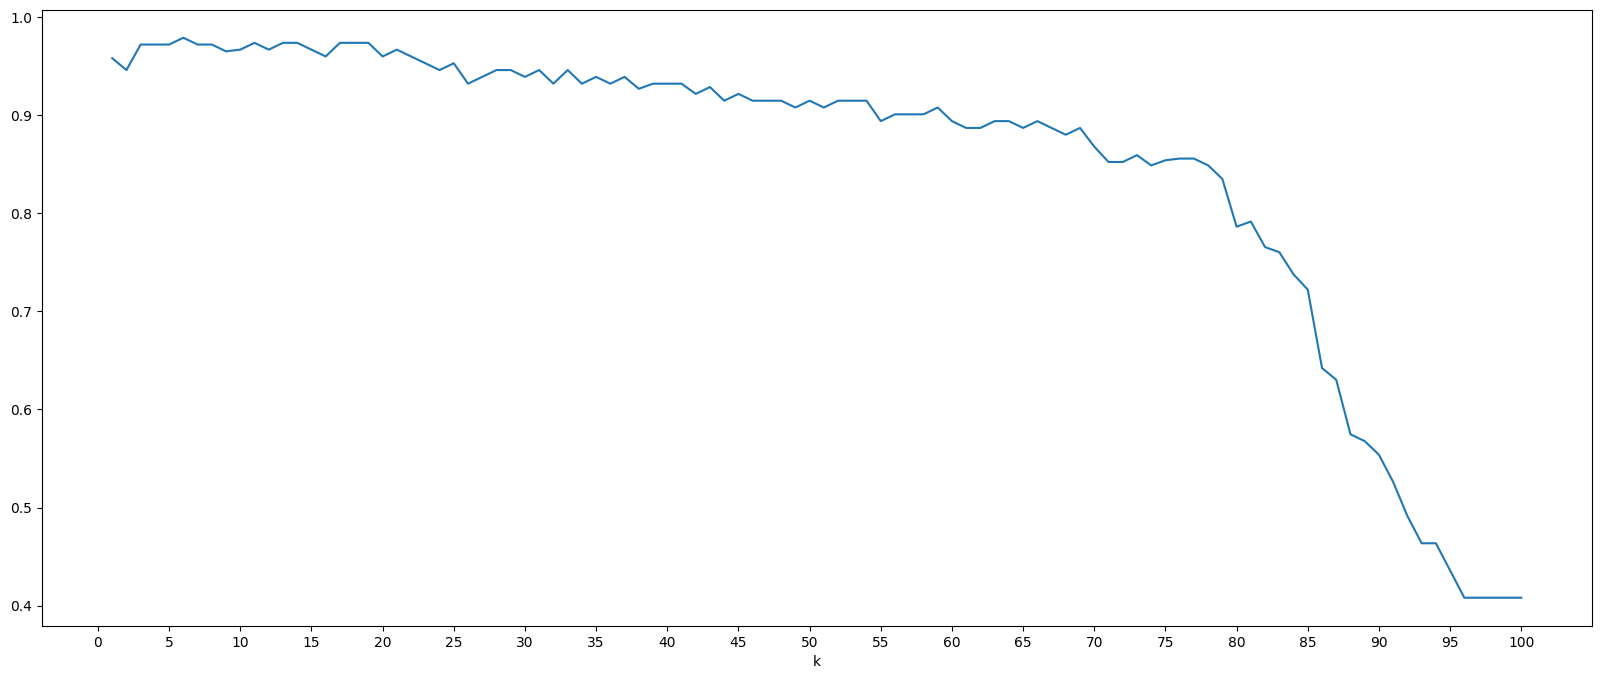

In [20]:
ks = [np.nan]
for k in range(1, 100 + 1):
  ks.append(test_knn_k_fold(iris_data, k, 8))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.plot(ks)
plt.xlabel("k")

In [65]:
np.min(ks[1:]), np.max(ks[1:]), np.average(ks[1:])

(0.40798611111111116, 0.9791666666666666, 0.8493923611111113)

Text(0.5, 0, 'no of folds')

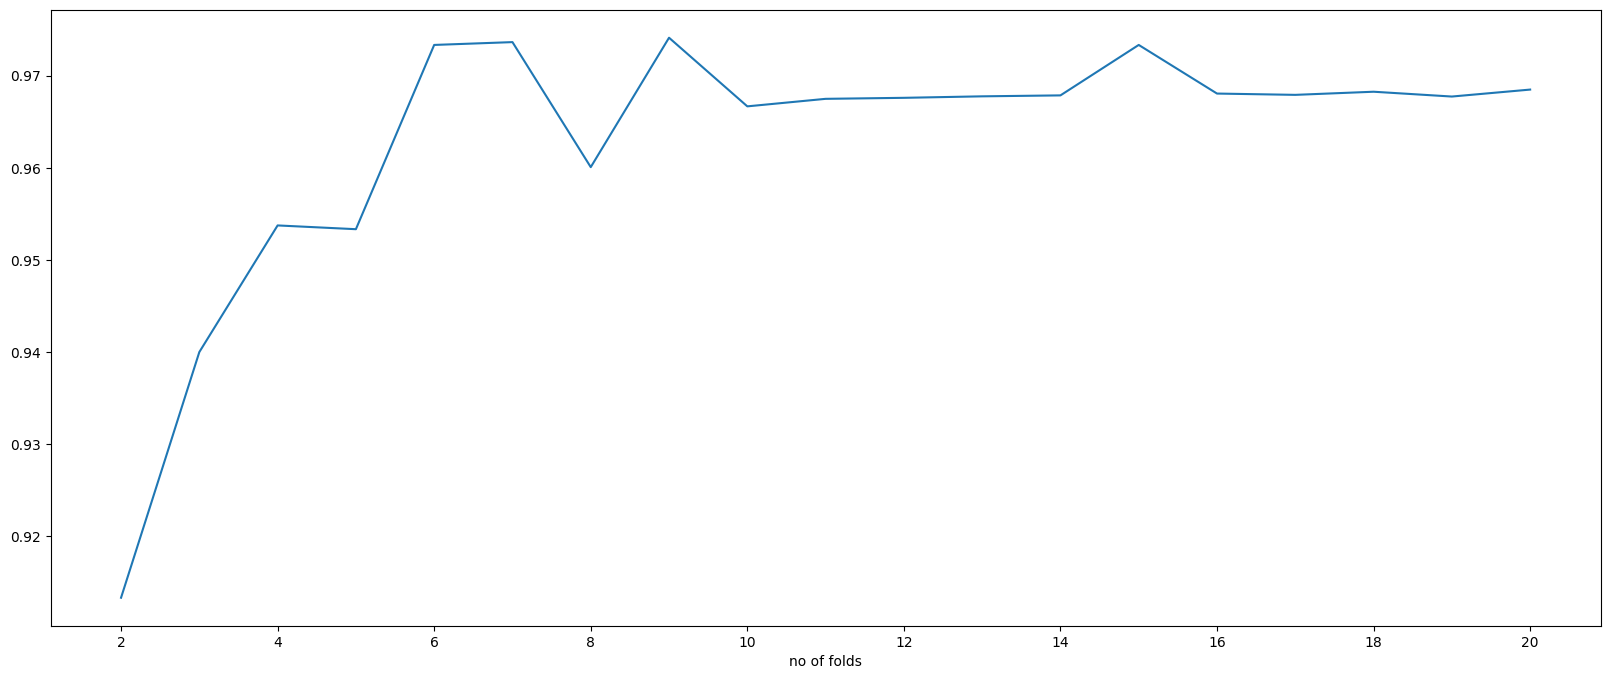

In [22]:
folds = [np.nan, np.nan]
for fold in range(2, 20 + 1):
  folds.append(test_knn_k_fold(iris_data, 16, fold))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(2, 40, 2))
plt.plot(folds)
plt.xlabel("no of folds")

### Rice

Text(0.5, 0, 'k of rice data')

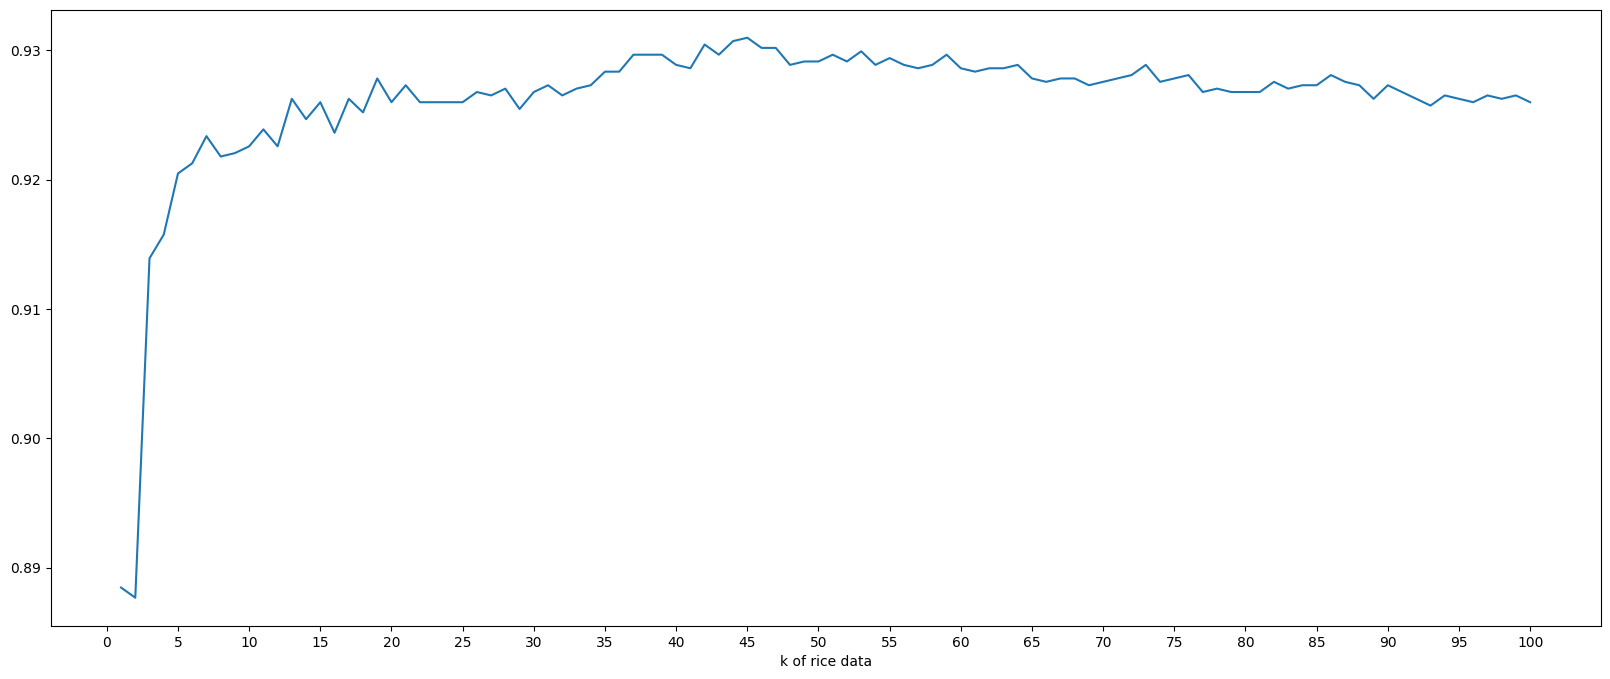

In [127]:
rice_min_max_normalize_copy = rice_min_max_normalize.copy()
rice_min_max_normalize_copy["class"] = rice_data["class"]
ks1 = [np.nan]
for k in range(1, 100 + 1):
  ks1.append(test_knn_k_fold(rice_min_max_normalize_copy, k, 3))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.plot(ks1)
plt.xlabel("k of rice data")

In [128]:
np.min(ks1[1:]), np.max(ks1[1:]), np.average(ks1[1:])


(0.8876640419947507, 0.9309711286089238, 0.9261653543307087)

Text(0.5, 0, 'no of fold rice data')

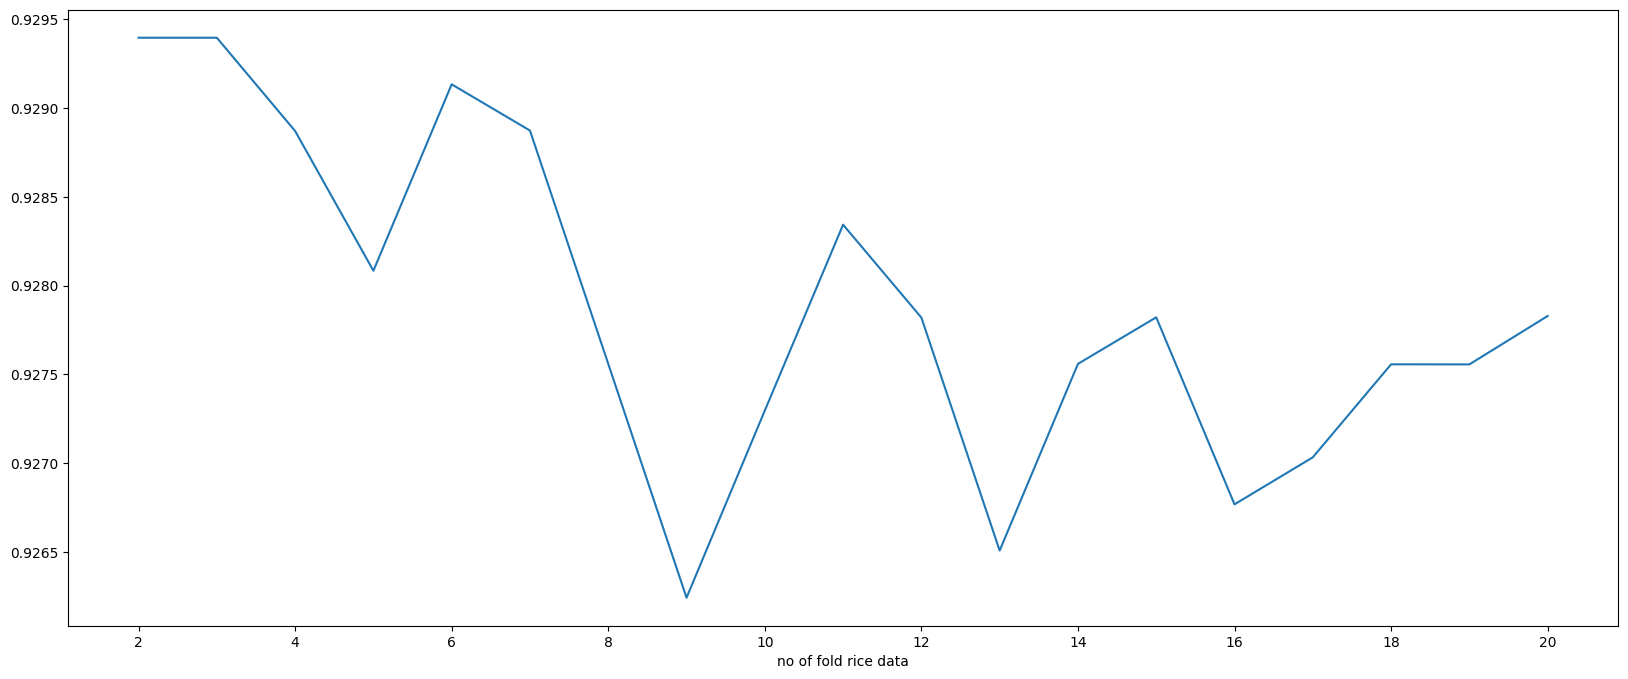

In [50]:
folds1 = [np.nan, np.nan]
for fold in range(2, 20 + 1):
  folds1.append(test_knn_k_fold(rice_min_max_normalize_copy, 55, fold))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(2, 40, 2))
plt.plot(folds1)
plt.xlabel("no of fold rice data")

### Wine

In [132]:
wine_standardization_copy = wine_standardization.copy()
wine_standardization_copy["class"] = wine_data["class"]

Text(0.5, 0, 'k of wine data')

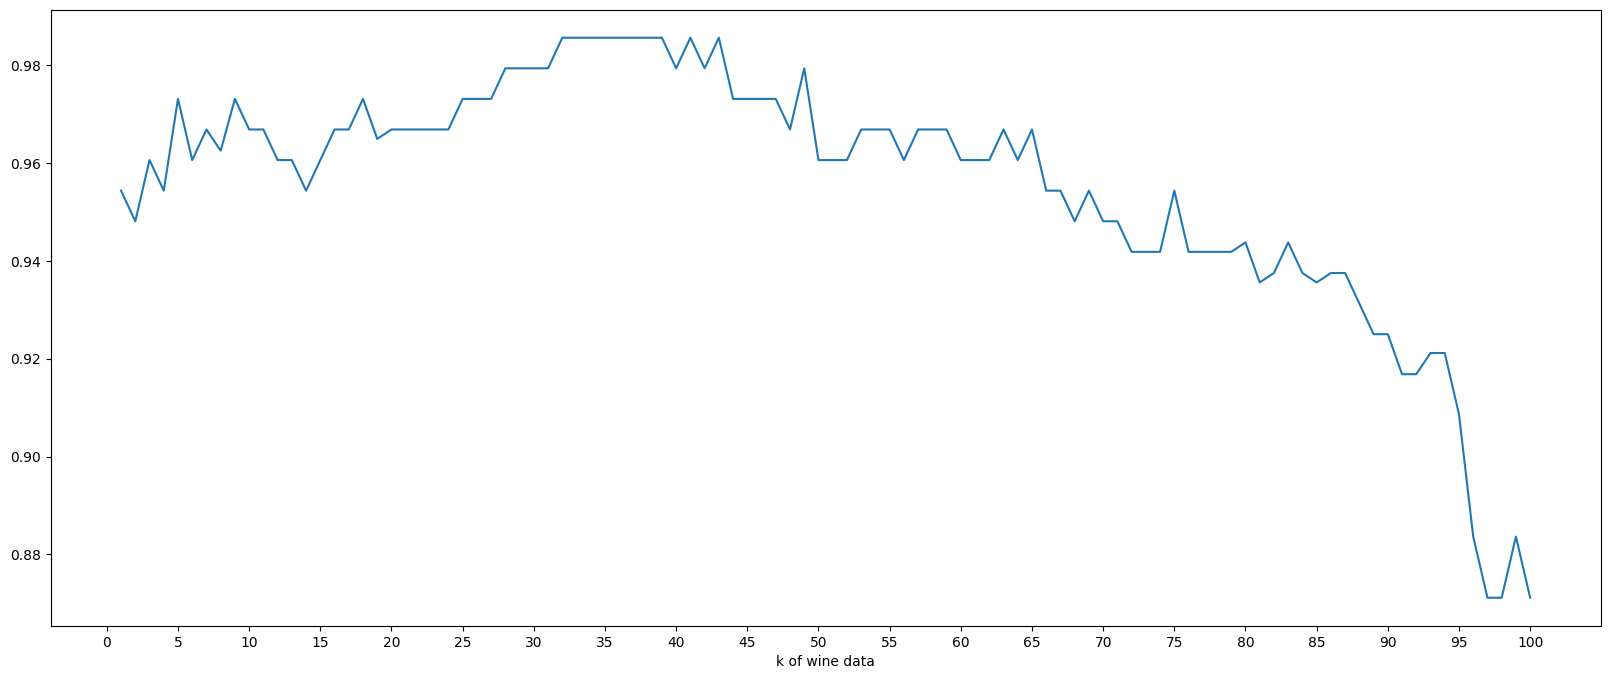

In [130]:
ks2 = [np.nan]
for k in range(1, 100 + 1):
  ks2.append(test_knn_k_fold(wine_standardization_copy, k, 20))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.plot(ks2)
plt.xlabel("k of wine data")

In [131]:
np.min(ks2[1:]), np.max(ks2[1:]), np.average(ks2[1:])


(0.8711538461538462, 0.985576923076923, 0.9554711538461537)

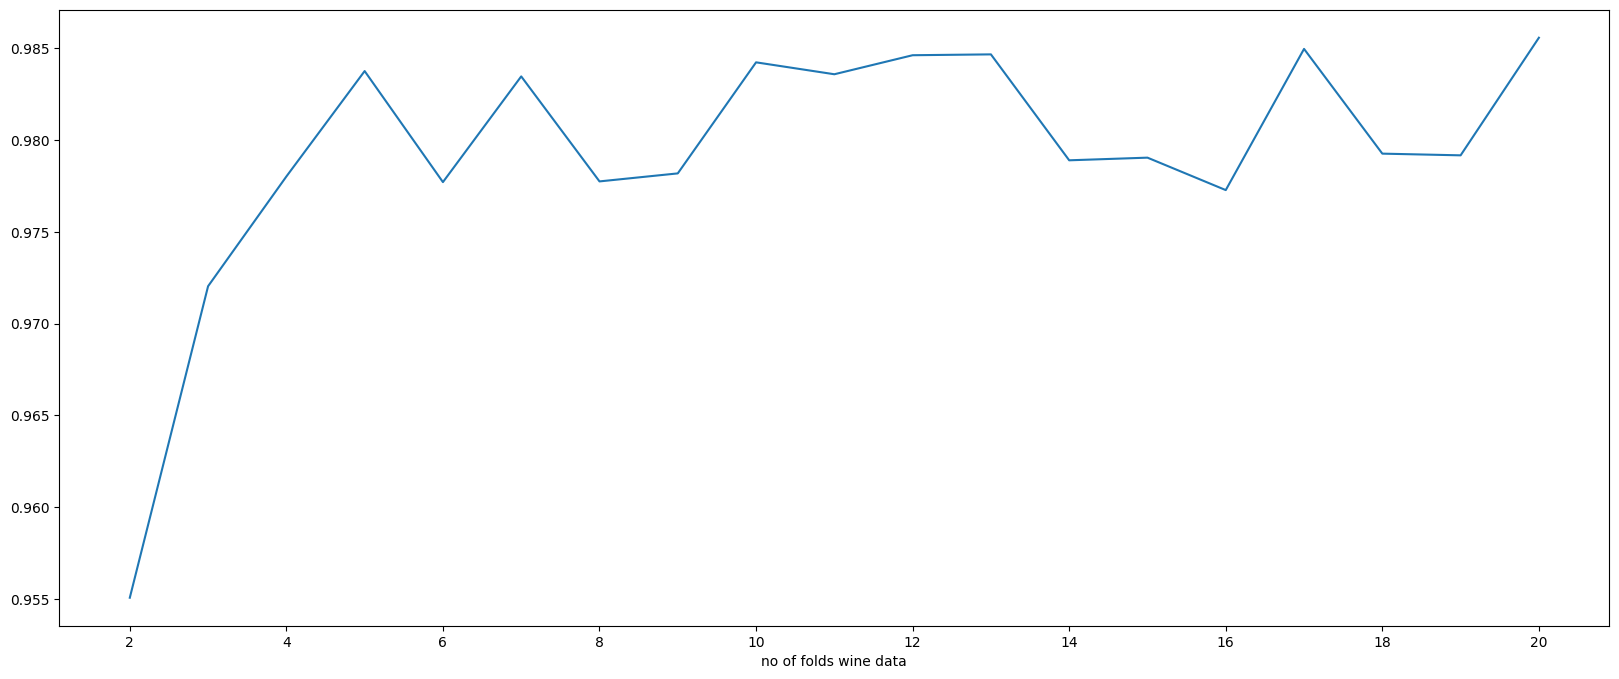

In [140]:
folds2 = [np.nan, np.nan]
for fold in range(2, 20 + 1):
  folds2.append(test_knn_k_fold(wine_standardization_copy, 35, fold))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(2, 40, 2))
plt.plot(folds2)
plt.xlabel("no of folds wine data")
plt.show()

# Leave one out

Text(0.5, 0, 'no of k')

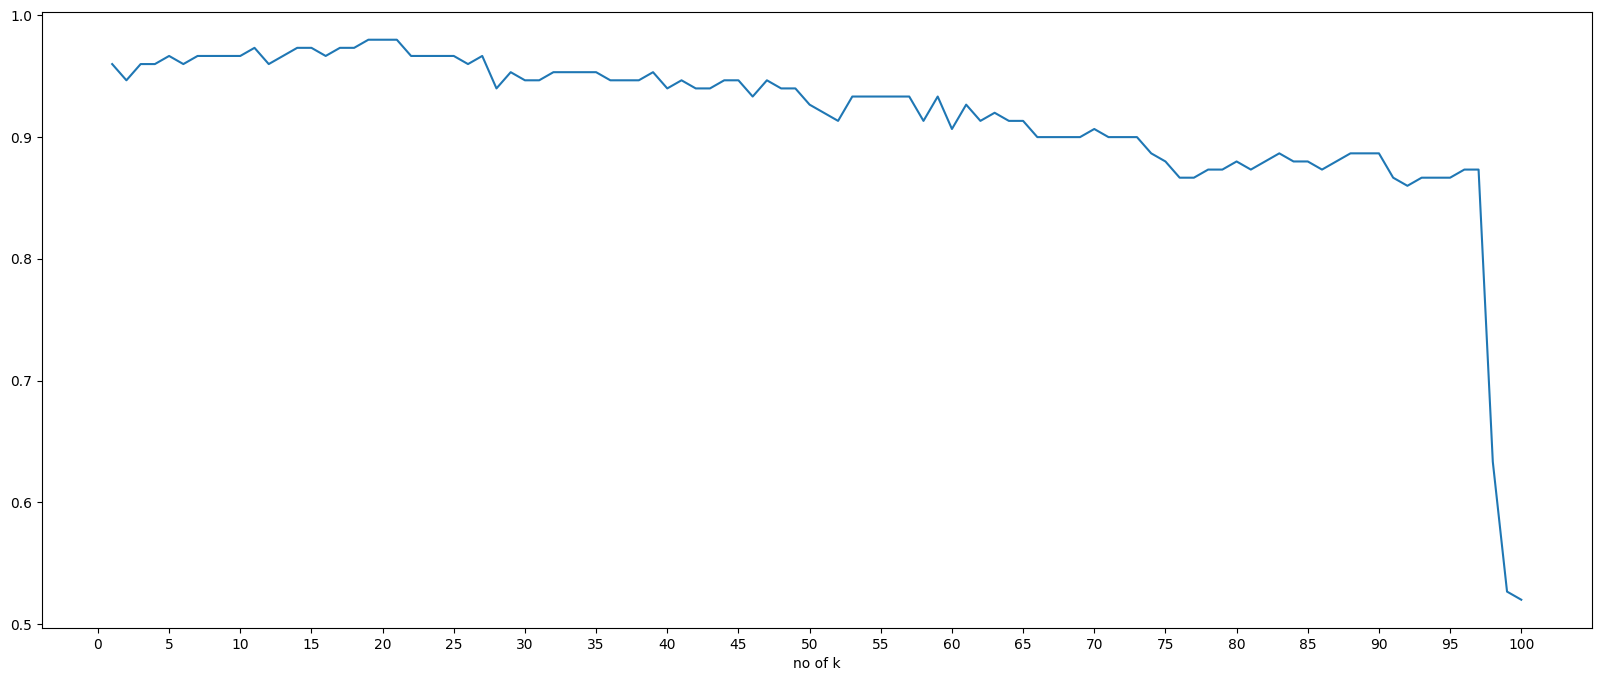

In [23]:
loo = []
for k in range(1, 100 + 1):
  loo.append(test_knn_leave_one_out(iris_data, k))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 105, 5))
plt.plot([np.nan, *loo])
plt.xlabel("no of k")

In [67]:
np.min(loo), np.max(loo), np.average(loo)

(0.52, 0.98, 0.9159333333333334)

In [39]:
from tqdm.notebook import tqdm

In [52]:
test_knn_leave_one_out(rice_min_max_normalize_copy, 50)

0.9270341207349081

In [40]:
loo1 = []
for k in tqdm(range(1, 20)):
  loo1.append(test_knn_leave_one_out(rice_data, k))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 105, 5))
plt.plot([np.nan, *loo1])
plt.xlabel("no of k")

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [134]:
test_knn_leave_one_out(wine_standardization_copy, 30)


0.9719101123595506

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'no of k')

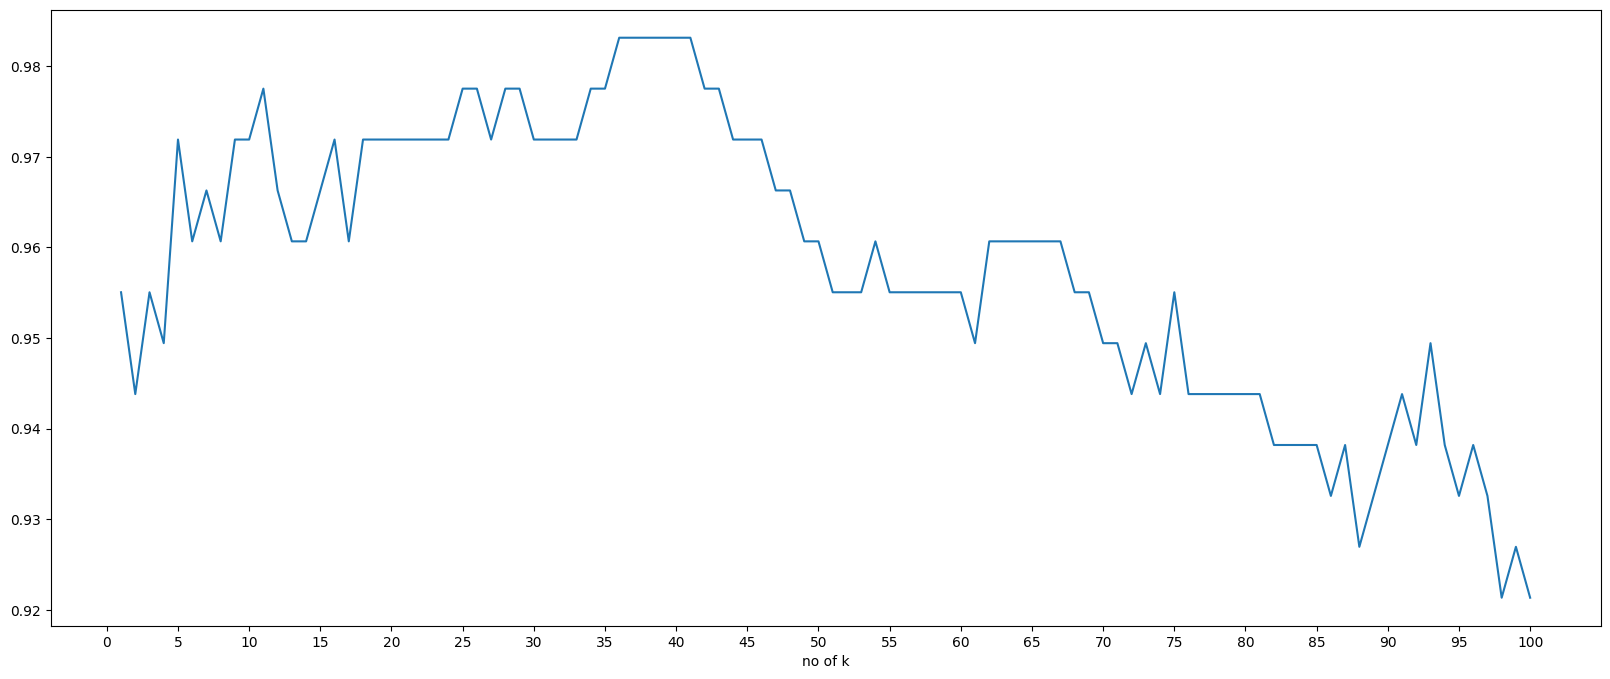

In [135]:
loo2 = []
for k in tqdm(range(1, 100 + 1)):
  loo2.append(test_knn_leave_one_out(wine_standardization_copy, k))


plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 105, 5))
plt.plot([np.nan, *loo2])
plt.xlabel("no of k")

In [139]:
np.min(loo2), np.max(loo2), np.average(loo2)

(0.9213483146067416, 0.9831460674157303, 0.9582022471910113)